In [298]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import itertools as it

In [299]:
training_data = np.loadtxt('../../NNQuST-master/benchmarks/c++/training_data.txt').astype(np.float32)
target_psi = np.loadtxt('../../NNQuST-master/benchmarks/c++/target_psi.txt').astype(np.float32)
target_psi = np.reshape(target_psi, (1024, 1))

In [300]:
class RBM:
    
    def __init__(self, train_data_file, num_hidden, num_visible, learning_rate, momentum, batch_size):
        
        # number of hidden units and visible units
        self.train_data_file = train_data_file
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.momentum = momentum   
        
        # initialize weights, visible bias and hidden bias
        self.weights = tf.Variable(tf.random_normal(shape=(self.num_visible, self.num_hidden), mean = 0.0, 
                                                    stddev = 0.1, dtype = tf.float32, seed = None, name = None), 
                                   tf.float32) # rows = num_hid, cols = num_vis
        
        self.hidden_bias = tf.Variable(tf.zeros(shape=(self.num_hidden,1)), tf.float32)
        self.visible_bias = tf.Variable(tf.zeros(shape=(self.num_visible,1)), tf.float32)
        
        # the 2 lines below,'all_hidden_states(self)' and are from Juan's tutorial 5 rbm.py code
        self._all_hidden_states = None
        self.max_feasible_for_log_pf = 24 
            
    def exact_log_partition_function(self):
        with tf.name_scope('exact_log_Z'):
            # Define the exponent: H*b + sum(softplus(1 + exp(a + w*H.T)))
            first_term = tf.matmul(self.all_hidden_states, self.hidden_bias, name='first_term')
            with tf.name_scope('second_term'):
                second_term = tf.matmul(self.weights, self.all_hidden_states, transpose_b=True)
                second_term = tf.nn.softplus(tf.add(self.visible_bias, second_term))
                second_term = tf.transpose(tf.reduce_sum(second_term, reduction_indices=[0], keep_dims=True))
            exponent = tf.cast(first_term + second_term, dtype=tf.float32, name='exponent')
            #exponent_mean = tf.reduce_mean(exponent)
            exponent_mean = tf.reduce_max(exponent)

            return tf.log(tf.reduce_sum(tf.exp(exponent - exponent_mean))) + exponent_mean
        
    @property
    def all_hidden_states(self):
        if self._all_hidden_states is None:
            assert self.num_hidden <= self.max_feasible_for_log_pf, \
                'cannot generate all hidden states for num_hidden > {}'.format(self.max_feasible_for_log_pf)
            self._all_hidden_states = np.array(list(it.product([0, 1], repeat=self.num_hidden)), dtype=np.float32)
        return self._all_hidden_states
    
    # Free energy function -> -(b.T)*v - sum(i)log( sum(h_i) exp(h_i*(c_i + W_iv)) )
    # Since we have to take exp(-free_energy) and free_energy is < 0
    # just compute -free_energy
    def free_energy(self, visible_samples):
        free_energy_  = tf.matmul(visible_samples, self.visible_bias)
        temp          = tf.reduce_sum(tf.nn.softplus(tf.matmul(visible_samples, self.weights) 
                                                     + tf.transpose(self.hidden_bias)),1)
        free_energy_ += tf.reshape(temp, shape = (visible_samples.shape[0], 1))
        
        return free_energy_
    
    # calculate NLL -> <log(p(v))> = - <F> + log(Z)
    def negative_log_likelihood(self, visible_samples, log_Z):       
        return -tf.reduce_mean(self.free_energy(visible_samples) - log_Z)      
    
    # Compute the exact value of the partition function (used for overlap)
    def exact_Z(self):
        return tf.to_float(tf.exp(self.exact_log_partition_function()))

    # prob of a hidden unit given a visible unit (can take batches of data)
    def prob_hidden_given_visible(self, visible_samples):
        arg = tf.matmul(visible_samples, self.weights) + tf.transpose(self.hidden_bias)
        return tf.nn.sigmoid(arg)
    
    # prob of a visible unit given a hidden unit (can take batches of data)
    def prob_visible_given_hidden(self, hidden_samples):
        arg = tf.matmul(hidden_samples, self.weights, transpose_b=True) + tf.transpose(self.visible_bias)
        return tf.nn.sigmoid(arg)

    # sample a hidden unit given a visible unit (can take batches of data)
    # see 'sample' function at end of class (samples a binary tensor)
    def sample_hidden_given_visible(self,visible_samples):
        b = tf.shape(visible_samples)[0] # the number of visible samples
        m = self.num_hidden 
        samples = self.sample(self.prob_hidden_given_visible(visible_samples), b, m)
        return samples

    # sample a visible unit given a hidden unit (can take batches of data)
    # see 'sample' function at end of class (samples a binary tensor)
    def sample_visible_given_hidden(self,hidden_samples):
        b = tf.shape(hidden_samples)[0] # the number of hidden samples
        n = self.num_visible
        samples = self.sample(self.prob_visible_given_hidden(hidden_samples), b, n)
        return samples

    # gibbs sampling for CD
    def gibbs_sampling(self, num_iters, v0_samples): # initialize a hidden sample from a batch of training data
                                                     # v0 -- matrix of shape (batch_size, num_visible)
        h0_samples = self.sample_hidden_given_visible(v0_samples)
        v_samples, h_samples = v0_samples, h0_samples 

        for i in range(num_iters):
            v_samples = self.sample_visible_given_hidden(h_samples)
            h_samples = self.sample_hidden_given_visible(v_samples)

        # spit out original visible and hidden samples, the reconstructed sample and the prob_h_given_v vector
        return v0_samples, h0_samples, v_samples, self.prob_hidden_given_visible(v_samples)
    
    # gradient of neg. log liklihood
    def grad_NLL_one_batch(self, batch, num_gibbs_iters):     
    
        # The 3 lines below are for debugging
        #w_grad  = tf.zeros_like(self.weights)
        #vb_grad = tf.zeros_like(self.visible_bias) # vb_grad = (num_vis, 1). hb_grad = (num_hid, 1)
        #hb_grad = tf.zeros_like(self.hidden_bias)

        # sample hidden and visible units via gibbs sampling
        v0, h0, vk, prob_h = self.gibbs_sampling(num_gibbs_iters, batch)

        # v0 and vk (batch_size, n_vis)
        # h0 and prob_h (batch_size, n_hidden)

        # calculate gradients for a batch of training data
        w_grad  = tf.matmul(tf.transpose(v0), h0) - tf.matmul(tf.transpose(vk), prob_h)
        
        # when calculating the gradients for the biases, tf.reduce_mean will divide the
        # gradients by the batch size.
        vb_grad = tf.reshape(tf.reduce_mean(v0 - vk, 0), shape = (self.num_visible,1))
        hb_grad = tf.reshape(tf.reduce_mean(h0 - prob_h, 0), shape = (self.num_hidden,1))
        
        # divide the weight gradient matrix by the batch size
        w_grad  /= tf.to_float(tf.shape(batch)[0])
        
        return w_grad, vb_grad, hb_grad

    # probability vector - for overlap
    def probability(self, visible_samples, Z):
        free_energy_ = self.free_energy(visible_samples)
        
        return tf.exp(free_energy_)/Z

    # square root of the probability vector - for overlap
    def sqrt_probability_vector(self, visible_samples, Z):
        return tf.sqrt(self.probability(visible_samples, Z))
    
    # overlap function -> <psi|sqrt(prob_vec)>
    def overlap(self, target_wavefunction, visible_space, Z):
        overlap_  = tf.matmul(tf.transpose(target_wavefunction), self.sqrt_probability_vector(visible_space, Z))
        return overlap_

    # for training function in main block of code. 
    # Just gets a batch from the training data
    def get_batch(self, index):
        batch_start = index*self.batch_size
        batch_end   = batch_start + self.batch_size 
        batch       = self.train_data_file[batch_start:batch_end,:]
        return batch
    
    # learning algorithm for 1 batch      
    def learn(self, num_gibbs_iters, batch):
        # calculate gradients for a batch
        weight_grad, visible_bias_grad, hidden_bias_grad = self.grad_NLL_one_batch(batch, num_gibbs_iters)

        # the lines below are for implementing momentum. Currently, I'm leaving it out. 
        
        # update velocities for momentum
        #new_weights_vel      = self.momentum*self.weights_vel      + self.learning_rate*weight_grad
        #new_visible_bias_vel = self.momentum*self.visible_bias_vel + self.learning_rate*visible_bias_grad
        #new_hidden_bias_vel  = self.momentum*self.hidden_bias_vel  + self.learning_rate*hidden_bias_grad     

        #update_weights        = tf.assign(self.weights, self.weights + new_weights_vel)
        #update_visible_biases = tf.assign(self.visible_bias, self.visible_bias + new_visible_bias_vel)
        #update_hidden_biases  = tf.assign(self.hidden_bias, self.hidden_bias + new_hidden_bias_vel)

        # update velocities
        #update_weights_vel      = tf.assign(self.weights_vel, new_weights_vel)
        #update_visible_bias_vel = tf.assign(self.visible_bias_vel, new_visible_bias_vel)
        #update_hidden_bias_vel  = tf.assign(self.hidden_bias_vel, new_hidden_bias_vel)

        # return [update_weights, update_visible_biases, update_hidden_biases, 
        # update_weights_vel, update_visible_bias_vel, update_hidden_bias_vel]
        
        # update weights and biases 
        update_weights        = tf.assign(self.weights, self.weights + self.learning_rate*weight_grad)
        update_visible_biases = tf.assign(self.visible_bias, self.visible_bias + self.learning_rate*visible_bias_grad)
        update_hidden_biases  = tf.assign(self.hidden_bias, self.hidden_bias + self.learning_rate*hidden_bias_grad)            
       
        return [update_weights, update_visible_biases, update_hidden_biases]

    # sample a binary tensor
    @staticmethod
    def sample(probs, m, n):
        return tf.where(
            tf.less(tf.random_uniform(shape=(m,n)), probs),
            tf.ones(shape=(m,n)),
            tf.zeros(shape=(m,n))
        )

    # generate all possible visible states (2**num_vis of them)
    @staticmethod
    def generate_all_possible_visibles(Nspins): # generate all configurations of 0 and 1 for 10 spins
        vis_space = np.zeros((2**Nspins, Nspins)).astype(np.float32)

        for i in range(2**Nspins): # rows  
            temp = i
            for j in range(Nspins): # columns
                temp, remainder = divmod(temp, 2)
                vis_space[i, j] = remainder 

        return vis_space

In [301]:
# -----------------------------------------------------------------------------------------------------------------------#
# --------------------------------------------- End of RBM class --------------------------------------------------------#
# -----------------------------------------------------------------------------------------------------------------------#
# must have this class to pass function arguments to functions that will
# be computed when the tf session starts
class Placeholders(object):
    pass

# shuffles the training data for SGD
def data_randomizer(data_file):
    shuffled_data = tf.random_shuffle(data_file)
    return shuffled_data

placeholders = Placeholders()

# main training function that will call the learn function in the rbm class
def train(training_data, num_epochs):
    
    # hard coded parameters
    num_hidden      = 10
    learning_rate   = 0.1
    num_visible     = training_data.shape[1]
    momentum        = 0.0
    batch_size      = 100
    num_batches     = int(training_data.shape[0]/batch_size)
    num_gibbs_iters = 10
    epoch_list      = []
    
    # intialize the rbm
    rbm = RBM(training_data, num_hidden, num_visible, learning_rate, momentum, batch_size)
    
    # placeholders for the visible samples (batches), the whole visible space, and the target psi
    placeholders.visible_samples     = tf.placeholder(tf.float32, shape=(batch_size, num_visible))
    placeholders.visible_space       = tf.placeholder(tf.float32, shape=(1024, num_visible))
    placeholders.target_wavefunction = tf.placeholder(tf.float32, shape=(1024, 1))
    
    # generate the entire visible space
    vis_space = rbm.generate_all_possible_visibles(num_visible)
    
    # placeholder for log(z) - for NLL
    logZ              = rbm.exact_log_partition_function()
    placeholders.logZ = tf.placeholder(tf.float32)
    NLL               = rbm.negative_log_likelihood(placeholders.visible_samples, placeholders.logZ)
    
    # placeholder for Z - for overlap
    Z              = rbm.exact_Z()
    placeholders.Z = tf.placeholder(tf.float32)
    OVERLAP        = rbm.overlap(placeholders.target_wavefunction, placeholders.visible_space, placeholders.Z)
    
    # a learning step to be ran once the session begins
    step = rbm.learn(num_gibbs_iters, placeholders.visible_samples)
        
    with tf.Session() as sess:
        # will hold NLLs after each epoch
        NLL_list = []
        
        # will hold NLLs for a batch during an epoch
        cost = []
        
        # will hold the overlap after each epoch
        OVERLAP_list = []
        
        # initialize the batch counter and epoch counter
        batch_count = 0
        epoch       = 0
        
        # initialize global variables to begin the tf session
        init = tf.global_variables_initializer()
        sess.run(init)
        
        # total number of steps = num_epochs*num_batches
        for i in range(num_epochs*num_batches):
            
            # if we have scanned through the entire training data set,
            # take the mean of the nll's over each batch, compute Z and the overlap
            if batch_size*batch_count + batch_size >= training_data.shape[0]:
                epoch_list.append(epoch)
                NLL_list.append(np.mean(cost))
                z = sess.run(Z)
                overlap = sess.run(OVERLAP, feed_dict = {placeholders.target_wavefunction: target_psi, 
                                                         placeholders.visible_space: vis_space, 
                                                         placeholders.Z: z})
                OVERLAP_list.append(overlap)
                #print 'Weights: >>> \n',sess.run(rbm.weights)
                print 'Epoch: %d, NLL >>> %g, OVERLAP >>> %g' % (epoch, np.mean(cost), overlap)
                
                # reset this list
                cost   = []
                epoch += 1
                
                # shuffle data again
                training_data = data_randomizer(training_data)
                batch_count = 0
            
            # compute log(Z) for nll of a batch          
            batch_count += 1
            new_batch = rbm.get_batch(batch_count)  
            sess.run(step, feed_dict = {placeholders.visible_samples: new_batch})
            lz = sess.run(logZ)
            nll = sess.run(NLL, feed_dict = {placeholders.visible_samples: new_batch, placeholders.logZ: lz})
            cost.append(nll)
            
    return NLL_list, OVERLAP_list, epoch_list

In [296]:
NLL_list, OVERLAP_list, epoch_list = train(training_data, 100)
#print OVERLAP_list
#print overlap_list

Epoch: 0, NLL >>> 6.82594, OVERLAP >>> 0.610156
Epoch: 1, NLL >>> 6.20446, OVERLAP >>> 0.716627
Epoch: 2, NLL >>> 5.36432, OVERLAP >>> 0.854247
Epoch: 3, NLL >>> 4.95505, OVERLAP >>> 0.907135
Epoch: 4, NLL >>> 4.85424, OVERLAP >>> 0.92198
Epoch: 5, NLL >>> 4.81882, OVERLAP >>> 0.929359
Epoch: 6, NLL >>> 4.79759, OVERLAP >>> 0.934716
Epoch: 7, NLL >>> 4.78411, OVERLAP >>> 0.935922
Epoch: 8, NLL >>> 4.77561, OVERLAP >>> 0.935393
Epoch: 9, NLL >>> 4.76944, OVERLAP >>> 0.940455
Epoch: 10, NLL >>> 4.75876, OVERLAP >>> 0.94315
Epoch: 11, NLL >>> 4.75441, OVERLAP >>> 0.94423
Epoch: 12, NLL >>> 4.74361, OVERLAP >>> 0.947811
Epoch: 13, NLL >>> 4.73516, OVERLAP >>> 0.950342
Epoch: 14, NLL >>> 4.72336, OVERLAP >>> 0.951709
Epoch: 15, NLL >>> 4.71406, OVERLAP >>> 0.950399
Epoch: 16, NLL >>> 4.69874, OVERLAP >>> 0.956545
Epoch: 17, NLL >>> 4.68581, OVERLAP >>> 0.959762
Epoch: 18, NLL >>> 4.67187, OVERLAP >>> 0.963657
Epoch: 19, NLL >>> 4.65372, OVERLAP >>> 0.965821
Epoch: 20, NLL >>> 4.63869, OVERL

101
101


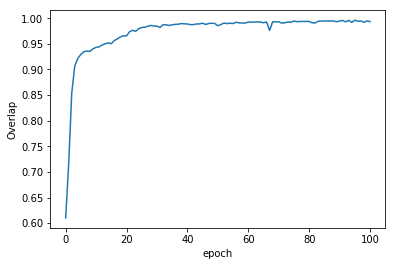

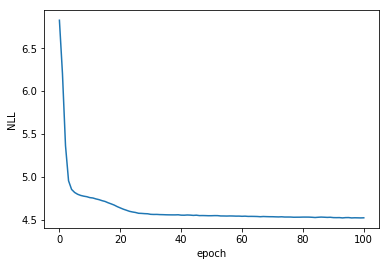

In [297]:
OVERLAP_list = np.reshape(OVERLAP_list, (np.shape(OVERLAP_list)[0]))
print len(NLL_list)
print len(epoch_list)
plt.figure(1)
plt.xlabel('epoch')
plt.ylabel('Overlap')
plt.plot(epoch_list, OVERLAP_list)
plt.savefig('overlap.png', format = 'png', dpi = 500)

plt.figure(2)
plt.xlabel('epoch')
plt.ylabel('NLL')
plt.plot(epoch_list, NLL_list)
plt.savefig('NLL.png', format = 'png', dpi = 500)